# CS565 Final Task

In [212]:
import sys
print(sys.version)

2.7.16 |Anaconda, Inc.| (default, Sep 24 2019, 16:55:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [213]:
import os
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/

Using Python version 2.7.16 (default, Sep 24 2019 16:55:38)
SparkSession available as 'spark'.


### Import graphframes if not already

In [3]:
# ! pyspark --packages graphframes:graphframes:0.5.0-spark2.1-s_2.11

# Load the Facebook Graph into Spark

In [214]:
from graphframes import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import functions as f
from pyspark.sql import Row
import re
import numpy as np

In [215]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
peopleids = [0, 107, 1684, 1912, 3437, 348, 3980, 414, 686, 698]
featids = ["id", "birthday"]
formatter = 'com.databricks.spark.csv'
vtx = Row(*featids)

# load the entire edge and node set into a Spark DataFrame
edf = sqlContext.read.format(formatter).options(delimiter=' ', \
    header='true', inferSchema=True) \
    .load('facebook_combined.txt')\
    .withColumnRenamed('C0', 'src').withColumnRenamed('C1', 'dst')

In [216]:
def featurematch(a, b):
    return "%s != 'None' and %s != 'None' and %s = %s" % \
            (a, b, a, b)

def fn_process(line):
    psd = re.search(
        r'\d+ (.*);anonymized feature (\d+)', line, re.IGNORECASE)
    if not psd:
        print ("parse error, line: %s") % line
        sys.exit(1)
    n = psd.group(1).replace(';', '_')
    #n = re.sub('_$', '', n)
    f = psd.group(2)
    return (n, f)

def feat_process(line, selfid):
    allents = line.split(' ')
    if (selfid != -1):
        return (selfid, allents)
    else:
        return (allents[0], allents[1:])

def get_feats(vtxid, mapping, feats):
    thisfeats = {}
    vtxfeats = []
    for idx, f in enumerate(feats):
        name, value = mapping[idx]
        if (f == '1'):
            thisfeats[name] = value
        else:
            thisfeats[name] = 'None'
    for ff in featids[1:]:
        vtxfeats.append(thisfeats[ff])
    return vtx(vtxid, *vtxfeats)


# Building a GraphFrame

In [217]:
alledges = sc.emptyRDD()
for personid in peopleids:
    featmap_fname = "facebook/%d.featnames" % personid
    feats_fname = "facebook/%d.feat" % personid
    this_feats_fname = "facebook/%d.egofeat" % personid

    # load the feature map
    fmap = []
    with open(featmap_fname) as flines:
        for line in flines:
            fmap.append(fn_process(line))

    # load the features for all the edges, and our own
    f_rdd = sc.textFile(feats_fname).map(lambda x: feat_process(x, -1)). \
         union(sc.textFile(this_feats_fname).map(lambda x: feat_process(x, personid)))

    # add the new data to the group
    alledges = f_rdd.map(lambda x: get_feats(x[0], fmap, x[1])).union(alledges)

# remove duplicates
print ("rdd raw count: %d") % alledges.count()

# create a GraphFrame from the result
vdf = sqlContext.createDataFrame(alledges, featids).dropDuplicates(['id'])
print ("vertex count: %d") % vdf.count()
print ("edge count: %d") % edf.count()
g = GraphFrame(vdf, edf)

rdd raw count: 4177
vertex count: 4039
edge count: 88234


# Find most mutual friend

In [163]:
res = g.find("(a)-[]->(b); (b)-[]->(c)")
res = res.filter("a.id != c.id and a.id != b.id and b.id != c.id ")

# get each person's mutual friends with someone else
res = res.groupBy("a.id", "c.id").count()
res = res.orderBy("a.id", "c.id", ascending = True)
res = res.toDF('aID', 'cID', 'mutual friends')
res.show(20)

# get max of each person's mutual friends with someone else
res = res.groupBy("aID").max("mutual friends")
res = res.orderBy("aID", ascending = True)
res = res.toDF('aID', 'mutual friends')
res.show(20)


mutual friend
+---+----+--------------+
|aID| cID|mutual friends|
+---+----+--------------+
|  0| 100|             1|
|  0|1000|             1|
|  0|1001|             1|
|  0|1002|             1|
|  0|1003|             1|
|  0|1004|             1|
|  0|1005|             1|
|  0|1006|             1|
|  0|1007|             1|
|  0|1008|             1|
|  0|1009|             1|
|  0| 101|             5|
|  0|1010|             1|
|  0|1011|             1|
|  0|1012|             1|
|  0|1013|             1|
|  0|1014|             1|
|  0|1015|             1|
|  0|1016|             1|
|  0|1017|             1|
+---+----+--------------+
only showing top 20 rows

+----+--------------+
| aID|mutual friends|
+----+--------------+
|   0|            65|
|   1|             8|
|  10|             8|
| 100|             3|
|1000|             7|
|1001|            12|
|1002|             1|
|1003|            73|
|1004|           104|
|1005|            11|
|1006|           118|
|1007|             8|
|1008|

# Create Histogram

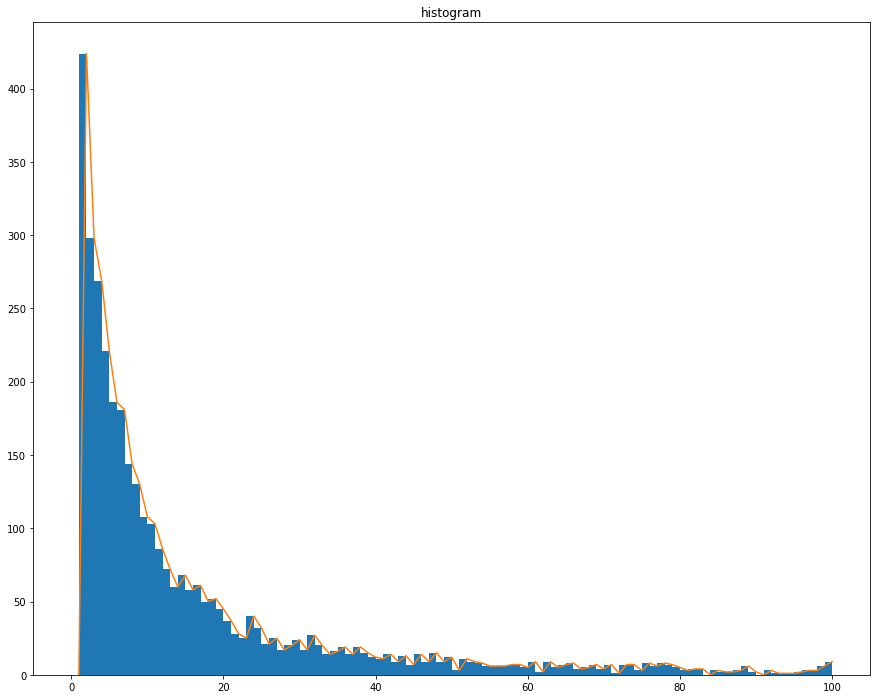

In [251]:
from matplotlib import pyplot as plt
%matplotlib inline

# data for histogram
res_array = np.array(res.select("mutual friends").collect()).ravel()
res_bins = np.linspace(0, 100, num=101)
res_y = np.histogram(res_array, bins=res_bins)[0]

# plotting
plt.figure(figsize=(15, 12))
plt.hist(res_array, bins = res_bins) 
plt.plot(res_bins[1:], res_y)
plt.title("histogram") 
plt.show()